# Air BNB Housing Styles and Prices in Boston

In this post I examine the dataset of AirBNB listing in the Boston area. Data is from [this kaggle dataset](https://www.kaggle.com/airbnb/boston) Plotting by region is inspired by the ResidentMario's excellent geoplot library and its documentation, which plots the price by location on this same dataset (however it is reprocessed here in different way) in its [gallery](https://residentmario.github.io/geoplot/gallery.html).

### Business Questions to Answer

The specific questions I seek to answer are these:

    1. Which areas (grouped by zipcode) have the highest price for AirBNB listing? Which have the lowest?
    2. What factors contribute most strongly to the price of a particular listing?
    3. What factors in the data are correlated, how can I reduce dimensionality and retain the most information?
    4. Are their clusters of listing types in the reduced dimensionality dataset?
    
### Dependencies

Packages required for this analysis are as follows:

shapely 1.6.4 <br>
scikit-learn 0.19.1 <br>
geopandas 0.4.0 <br>
geoplot 0.2.3 <br>
quilt 2.9.15 <br>

### Using quilt

One note on the quilt library. Quilt is a library for maintaing version controlled datasets, for easy access and reproduction later. In order to map the map plots from the geopandas examples, you will need to use quilt to install the data library from ResidentMario cited above. To install this quilt dataset run the following command:

<code> import quilt </code> <br>
<code> quilt.install("ResidentMario/geoplot_data") </code>

Then you will be able to call data from this data libray like this:

<code> from quilt.data.ResidentMario import geoplot_data </code>

# Section 1 - Cleaning up the AirBNB data for further analysis

In [1]:
def clean_airBNB_data(path):

    '''Provided a local path to the kaggle data linked in introduction, extracts all data to numerical features, 
    including turning categories into dummy variables. Also creates a geometry column as a shapely point object for plotting
    
    Input 
        path: local path to read csv data
    
    Output 
        clean_df: which is all cleaned data except the amenities column
        clean_df_amen: which additional splits out the amenities column into categorical dummies
    '''
    
    import numpy as np
    import pandas as pd
    from shapely.geometry import Point
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import Imputer
    import warnings
    warnings.filterwarnings('ignore')

    # read data
    df = pd.read_csv(path)
    
    # these are catagorical variables, they need to be dummied
    cat_list = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact',
                'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
                'property_type','room_type','bed_type']

    cat_df = pd.get_dummies(df[cat_list], prefix=cat_list, drop_first=True)

    # keep numerical data where are least half of the rows have some data, ignoring the rest
    num_df = df.select_dtypes(['int','float'])
    num_df = num_df[num_df.columns[num_df.isnull().sum()/num_df.shape[0] < 0.5]]

    # impute missing values with mean of that column
    imp = Imputer()
    num_df = pd.DataFrame(columns=num_df.columns, data=imp.fit_transform(num_df))

    # these variables are strings that need converting to floats
    dollar_list = ['price','security_deposit','extra_people','cleaning_fee', 'host_acceptance_rate']

    dol_df = df[dollar_list]
    for entry in dollar_list:
        row_num = df[entry].str.extract('(\d+)').values.astype('float')
        dol_df.loc[:,entry + '_num'] = row_num

    dol_df.drop(dollar_list, axis=1, inplace=True)

    # this varible has lots of missing values
    dol_df['host_acceptance_rate_num'].fillna(dol_df['host_acceptance_rate_num'].mean(), inplace=True)
    dol_df.fillna(0, inplace=True)

    # extract out the amenities column, which has a list of amenities for each row, which need to be extracted, and dummied
    amenities = df['amenities'].str.split('([A-Z][\w ]+)', expand=True)

    # split creates columns for stuff in between groups too, ignore those
    i = 1
    for col in amenities.columns:
        if i%2 == 1:
            amenities.drop(col, axis=1, inplace=True)
        i += 1

    # explictly loop through every entry to keep track of categorical dummies, since everything is jumbled and out of order
    rows = amenities.shape[0]
    columns = amenities.shape[1]

    to_drop = amenities.columns

    for i in range(rows):
        for j in range(columns):

            entry = amenities.iloc[i,j]

            if entry:
                amenities.loc[i, entry + '_bin'] = 1

    amenities.drop(to_drop, axis=1, inplace=True)
    
    # everything that was not assigned a 1 is logically now a 0
    amenities.fillna(0, inplace=True)

    # combine all the various extracted data back together
    clean_df_amen = pd.concat((cat_df, dol_df, num_df, amenities), axis=1)
    clean_df = pd.concat((cat_df, dol_df, num_df), axis=1)

    # add in a location column as a shapely point object for geopandas map plotting
    df['geometry'] = list(zip(df.longitude, df.latitude))
    clean_df['geometry'] = df['geometry'].apply(Point)
    clean_df_amen['geometry'] = df['geometry'].apply(Point)
    
    # also keep track of zipcode, since this will serve as a join for plotting
    clean_df['zipcode'] = pd.to_numeric(df['zipcode'], errors='coerce')
    clean_df_amen['zipcode'] = pd.to_numeric(df['zipcode'], errors='coerce')
    
    return clean_df, clean_df_amen

In [2]:
clean_df, clean_df_amen = clean_airBNB_data('listings.csv')

In [3]:
clean_df.head()

,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,is_location_exact_t,instant_bookable_t,require_guest_profile_picture_t,require_guest_phone_verification_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,geometry,zipcode
0,0,1,0,1,0,0,0,0,0,0,...,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,1.970908,POINT (-71.13306792912681 42.28261879577949),2131.0
1,0,1,1,1,1,0,0,0,0,0,...,94.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.300000,POINT (-71.13437396457161 42.28624082186742),2131.0
2,1,1,1,1,0,1,0,0,0,0,...,98.000000,10.000000,9.000000,10.000000,10.000000,9.000000,10.000000,0.470000,POINT (-71.13576525374667 42.29243788665679),2131.0
3,0,1,0,0,0,0,0,0,0,0,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,POINT (-71.12102117350554 42.28110618827365),NaN
4,1,1,1,1,0,0,0,0,0,0,...,99.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,2.250000,POINT (-71.1362580468337 42.28451220982457),2131.0


In [4]:
clean_df.shape

(3585, 45)

In [5]:
clean_df_amen.head()

,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,is_location_exact_t,instant_bookable_t,require_guest_profile_picture_t,require_guest_phone_verification_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Camper/RV,...,Smoking Allowed_bin,Suitable for Events_bin,Wheelchair Accessible_bin,Elevator in Building_bin,Pool_bin,Doorman_bin,Paid Parking Off Premises_bin,Free Parking on Street_bin,geometry,zipcode
0,0,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-71.13306792912681 42.28261879577949),2131.0
1,0,1,1,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-71.13437396457161 42.28624082186742),2131.0
2,1,1,1,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-71.13576525374667 42.29243788665679),2131.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-71.12102117350554 42.28110618827365),NaN
4,1,1,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT (-71.1362580468337 42.28451220982457),2131.0


In [6]:
clean_df_amen.shape

(3585, 90)

In [7]:
clean_df.isna().sum()

host_is_superhost_t                    0
host_has_profile_pic_t                 0
host_identity_verified_t               0
is_location_exact_t                    0
instant_bookable_t                     0
require_guest_profile_picture_t        0
require_guest_phone_verification_t     0
property_type_Bed & Breakfast          0
property_type_Boat                     0
property_type_Camper/RV                0
property_type_Condominium              0
property_type_Dorm                     0
property_type_Entire Floor             0
property_type_Guesthouse               0
property_type_House                    0
property_type_Loft                     0
property_type_Other                    0
property_type_Townhouse                0
property_type_Villa                    0
room_type_Private room                 0
room_type_Shared room                  0
bed_type_Couch                         0
bed_type_Futon                         0
bed_type_Pull-out Sofa                 0
bed_type_Real Be

The data is now in all numerical formats (i.e. all categoricals have been dummied) in a form suitable for performing some machine learning. Note that at this point at the missing data has been treated by either dropping columns with more than half of the data missing, or in less than half was missing, the values were treated by mean imputing. 

Two of the columns deserves special note. The geometry column is in the form of a shapely [point object](https://shapely.readthedocs.io/en/stable/manual.html#points). This is really useful to make geopandas plots, as will be discussed below. It is constructed from the longitude and latitude columns, and represents a location, which can be checked easily against other geometries, for example to check whether it is within a [polygon object](https://shapely.readthedocs.io/en/stable/manual.html#polygons) that bounds a particular area on a map. Secondly, zipcode is just retained to serve as the join column for grouping data, following the example in the [geopandas documentation](https://residentmario.github.io/geoplot/gallery.html).

Also note the difference in size of the data with ammenities dummied, versus with them excluded. There are a lot of possible ammenities, and so this ends up eating up a large amount of the columns if this is included. Data will be fit with and without this additional data in the price analysis section.

# Section Two - Regional Analysis of Price

In [8]:
def make_map_plot(df, hue, agg_method, fig_name, title):
    
    '''Directly taken from the geoplot gallery example on aggplot, which plots the same data as analyzed here,
       but cleaning is not described in that case
    
    Input
    
        df: the dataframe which contains a shapely point object locaiton columns, and some numerical value to plot
        hue: the numerical column to use for shading the map of boston
        agg_method: how to apply the hue, accepts mean or median
        fig_name: how to save the figure generated by the map plot
        title: how to title the plot
        
    Output
        
        inline plots a figure and saves this figure as a .png'''
    
    import geoplot as gplt
    import geoplot.crs as gcrs
    import numpy as np
    import matplotlib.pyplot as plt
    from quilt.data.ResidentMario import geoplot_data
    import geopandas as gpd
    import pandas as pd
    import numpy as np

    if agg_method == 'mean':
        agg = np.mean
    elif agg_method == 'median':
        agg = np.median
        
    # first you need to create a geopandas dataframe, which is like a pandas dataframe with coordinate attributes from shapely
    abb = gpd.GeoDataFrame(df, geometry='geometry')
    
    # nans will mess up plotting, also the 2218 zipcode is not contained in the map boudnaries for some reason
    abb.dropna(inplace=True)
    abb = abb[abb['zipcode'] != 2218.0]

    # read in .shp zipcode boundaries from ResidentMario's quilt database
    boston_zip_codes = gpd.read_file(geoplot_data.boston_zip_codes())
    boston_zip_codes = boston_zip_codes.assign(id=boston_zip_codes.id.astype(float)).set_index('id')

    # create the plot outlines of the zipcodes
    ax = gplt.polyplot(boston_zip_codes.geometry, projection=gcrs.AlbersEqualArea(),
                       facecolor='white', edgecolor='gray',figsize=(15,15), linewidth=0)
    
    plt.rcParams.update({'font.size': 22}) 
    
    # shade the regions based on price, as per example in geoplot gallery, should match that link and does for me
    gplt.aggplot(abb, projection=gcrs.AlbersEqualArea(), hue=hue,
                 by='zipcode', geometry=boston_zip_codes.geometry, agg=agg, ax=ax,
                 linewidth=0, legend_kwargs={'fraction': 0.045})
    
    ax.set_title(title, fontdict={'fontsize':28})
    plt.savefig(fig_name, bbox_inches='tight', pad_inches=0.1)

In [9]:
def make_points_plot(df, hue, fig_name, title):
    
    '''Rather than an aggplot, this funciton will just make a scatter plot and color by hue instead
    
    Input
    
        df: the dataframe which contains a shapely point object locaiton columns, and some numerical value to plot
        hue: the numerical column to use for shading the map of boston
        fig_name: how to save the figure generated by the map plot
        title: how to title the map plot
        
    Output
        
        inline plots a figure and saves this figure as a .png'''
    
    import geoplot as gplt
    import geoplot.crs as gcrs
    import numpy as np
    import matplotlib.pyplot as plt
    from quilt.data.ResidentMario import geoplot_data
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    from shapely.geometry import Point, Polygon
        
    # first you need to create a geopandas dataframe, which is like a pandas dataframe with coordinate attributes from shapely
    abb = gpd.GeoDataFrame(df, geometry='geometry')

    # read in .shp zipcode boundaries from ResidentMario's quilt database
    boston_zip_codes = gpd.read_file(geoplot_data.boston_zip_codes())
    boston_zip_codes = boston_zip_codes.assign(id=boston_zip_codes.id.astype(float)).set_index('id')
    
    # only keep those that are in the kaggle date
    boston_zip_codes = boston_zip_codes.loc[abb['zipcode'].unique(),:].dropna()

    # create the plot outlines of the zipcodes
    ax = gplt.polyplot(boston_zip_codes.geometry,facecolor='lightgray', alpha=0.2, edgecolor='gray',figsize=(15,15))
    gplt.pointplot(abb, hue=hue, cmap='viridis', ax=ax, legend=True);
    
    ax.set_title(title, fontdict={'fontsize':28})
    plt.savefig(fig_name, bbox_inches='tight', pad_inches=0.1)

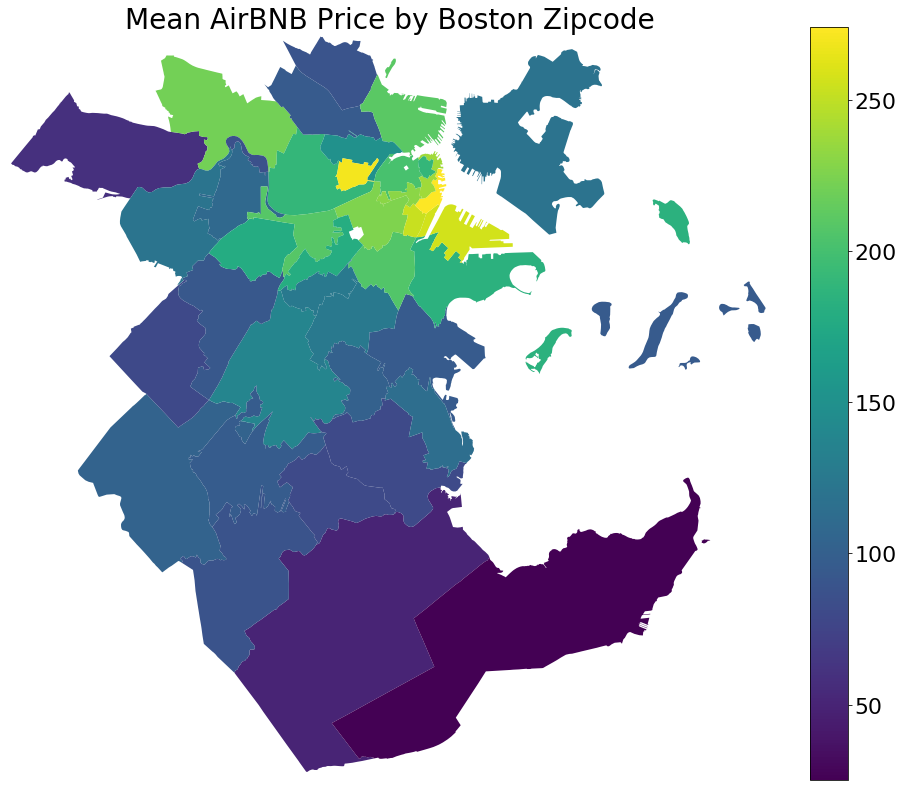

In [10]:
make_map_plot(clean_df, 'price_num', 'mean', 'mean_airbnb_price.png', 'Mean AirBNB Price by Boston Zipcode')

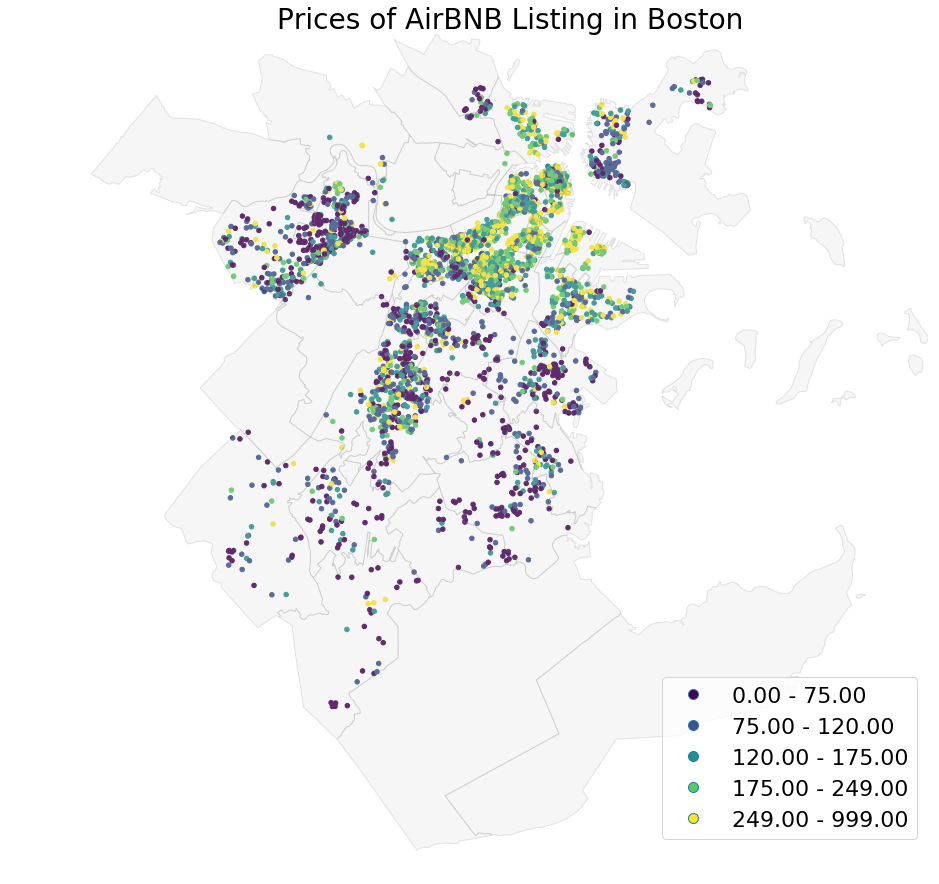

In [11]:
make_points_plot(clean_df, 'price_num', 'airbnb_price_scatter.png', 'Prices of AirBNB Listing in Boston')

Isn't this an awesome plot!!! Hats off to ResidentMario, I love geopandas for making maps. I am going to follow up this post with one look at housing price variations over time in California, stay tuned. 

In particular, this plotting function uses both the polyplot function (to plot the outlines of the zipcode boundaries), as well as the aggplot function (which will shade those polygons based on some statistical measure of a given column, here price and average, of all the points that lie in that boundary).

Now this might be out of order, looking a regional variations in price before establishing this as a strong predictor of price, but based on outside knowledge everyone has about real estate, it would be mind boggling if location did not account for a large amount of the variance in price. Clearly most people would pay more to stay near [downtown Boston](https://www.google.co.jp/maps/place/%E3%82%A2%E3%83%A1%E3%83%AA%E3%82%AB%E5%90%88%E8%A1%86%E5%9B%BD+%E3%83%9E%E3%82%B5%E3%83%81%E3%83%A5%E3%83%BC%E3%82%BB%E3%83%83%E3%83%84%E5%B7%9E+%E3%83%9C%E3%82%B9%E3%83%88%E3%83%B3+%E3%83%80%E3%82%A6%E3%83%B3%E3%82%BF%E3%82%A6%E3%83%B3/@42.3448093,-71.1561321,11.57z/data=!4m5!3m4!1s0x89e370832503ad5b:0x18d02d6e8684bd98!8m2!3d42.3557089!4d-71.0572053) than in the outlying suburbs (fun fact, i was in Japan while writing this, hence the Japanese plus english on the goggle maps link). 

Looking at the second plot, we are reminded of the dangers of blinding shading map plots without acutally seeing how many datapoints fall into each zone. It is obvious here that there general trend suggested by the aggplot is true, it also clear that drwing conlusions about the regions near Sommerville and Cambridge, is impossible, since there are many fewer datapoints here. Probably one of the more striking conclusions here is just how fe AirBNBs there are in the wealthier suburbs.

# Section 3 - Fitting a Linear Regressor to Determine Variables Impacting Price

In [12]:
def fit_SGD_regress(clean_df):
    
    '''Takes the cleaned dataframes, applies standard scaler, and then fits the data with stochastic gradient decent and L2
    
    Input
    
    clean_df: one of the cleaned datasets returned from the clean_air_BNB function
    
    Output
    
    score - R2 of the model predictions vs. the test data
    fit_df - dataframe containing the summary of the fit coefficients for analysis
    sgd - SGDRegressor object
    scl - StandardScaler object'''

    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.linear_model import SGDRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score
    from sklearn.preprocessing import StandardScaler
    
    # need to drop the output column, and the zipcode, since it is redundant with the longitude and latitude
    # also there are very few campers and rvs, so they are excluded also
    X = clean_df.drop(['price_num', 'geometry', 'property_type_Camper/RV', 'zipcode'], axis=1)
    categories = X.columns
    y = clean_df['price_num']

    # standard scaling of data for input to regressor
    scl = StandardScaler()
    model = scl.fit(X)
    X_scl = model.transform(X)

    # split into testing and training sets at 1/3 ratio
    X_train, X_test, y_train, y_test = train_test_split(X_scl, y, test_size=0.33, random_state=42)

    # initiate SGD object and fit to data, fixing random state for reproducibility
    sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
    sgd.fit(X_train, y_train)

    # predict test data and calculate score
    y_pred = sgd.predict(X_test)
    score = r2_score(y_test, y_pred)

    # keep track of coefficients for analysis
    fit_df = pd.Series(index=categories, data=sgd.coef_).sort_values()
    
    # plot the values of coefficients to see what inputs dominate the model
    plt.figure(figsize=(15,8))
    plt.rcParams.update({'font.size': 10}) 
    plt.bar(fit_df.index, fit_df.values);
    plt.xticks(fit_df.index, fit_df.index, rotation='vertical');
    plt.title('SGD Regressor Fit Coefficients', fontdict={'fontsize':28})
    print('R2 = ' + str(score))
    plt.savefig("SGD_regressor_fits.png", bbox_inches='tight', pad_inches=0.1)

    return score, fit_df, sgd, scl

Now with this fitting pipeline in hand, lets fit both of the cleaned Dataframes, the ones with and without the ammenities to see how good a job that the stochastic gradient descent regressor with L2 loss can do at predicting the price (based on the R$^2$ metric).

R2 = -0.05806123362093141


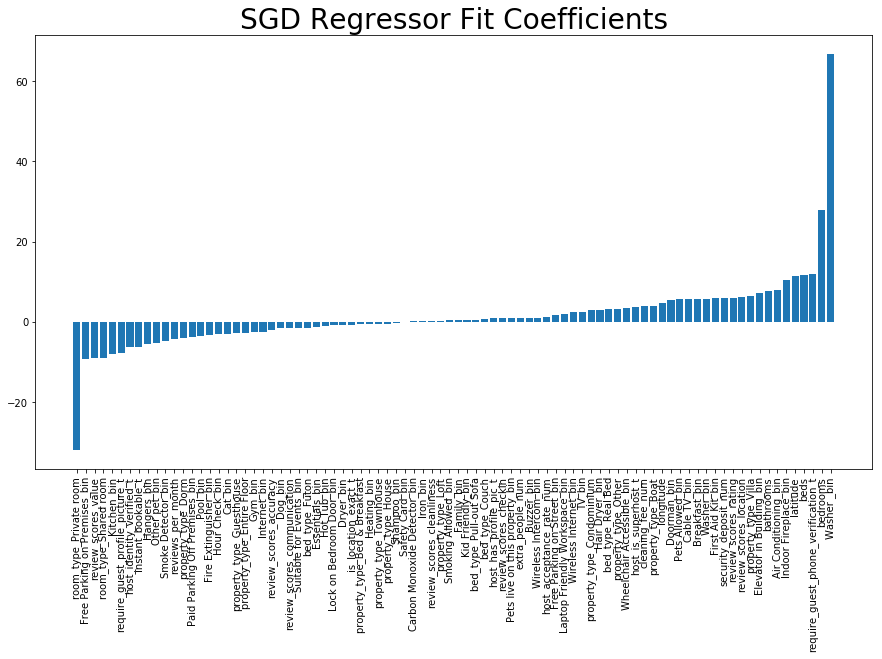

In [13]:
# Fit the DataFrame with the ammenities
score, fit_df, sgd, scl = fit_SGD_regress(clean_df_amen)

Ooomph, that is pretty bad. Lets try when half of the columns are not different types of ammenities.

R2 = 0.5064732646487407


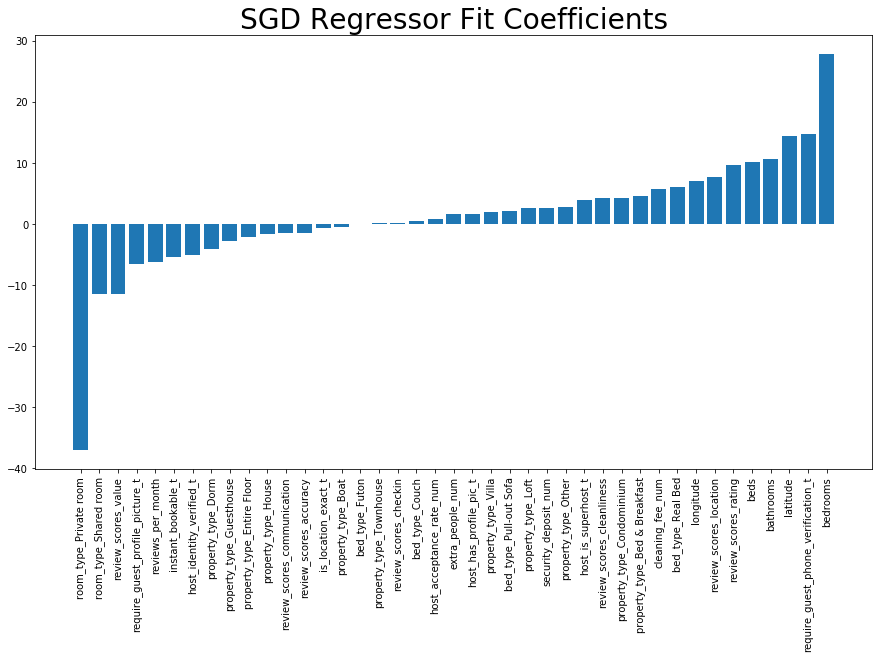

In [14]:
# Fit the DataFrame without all the ammenities
score, fit_df, sgd, scl = fit_SGD_regress(clean_df)

Much better!

Probably the ammenities are not so important in determining price, and including so many irrelevant variables. Note that in the this case that location is treated by the individual latitude and longitude coordinates, and the zipcode is ignored for fitting, since including both would be redundant, and I prefer the continous variable in this case, as it is more specific and does not impose strict discontinuities between points that are close to the edges of the boundaries. 

All variables are treated with the standard scaler prior to linear fitting for ease of comparison afterwards (all the coefficients will then automatically be on the same scale).The output plot shows all of the coefficients from the linear regression, organized from smallest to largest. A large negative coefficient means the price goes down as this factor goes up, whereas a large postive coefficient means that price and tha variable increase together.

Lets think about the top five and bottom five more closely:

Strong positive correlation with price:

    1. bedrooms
    2. requires_guest_phone_verification
    3. latitude
    4. bathrooms
    5. beds
    
This makes intuitive sense. Bedrooms, bathrooms, beds all relate to the size of the house. Of course larger houses can house more guests, and therefore allow one to charge more. Latitude also makes sense based on the map above. Actually if dataset was not layed of so cleaning, with the more expensive houses being near the northmost edge (latitude), and towards the eastern edge (longitude), then fitting the coordinates with a linear regressive in this way would probably be a bad idea (as the responsive would be non-linear). Here it does not seem that unjustified, and based on the map, it matches our previous visualization.

Strong negative correlation with price:

1. room_type_private_room
2. room_type_shared_room
3. review_scores_value
4. require_guest_profile_picture
5. reviews_per_month

Again I would say these make alot of sense. Guest prefer not to share in an AirBNB where the owner is there, they would rather pay for privacy (and the owner saves convenience by not needing to leave). I cannot imagine why someone would require a picture in order to rent an AirBNB, verus just their user user rating, this seems like it is potentially misconstrued as being midly racist. Review score of value is obvious, a place likely to be rated as a good value is probably cheaper.

The two non-obvious ones I think are reviews per month and requiring guest phone verification. My hypothesis is that if a place is super nice, then it would be prudent for the renter to require phone verification, as an insurance against guests who treat places badly. 

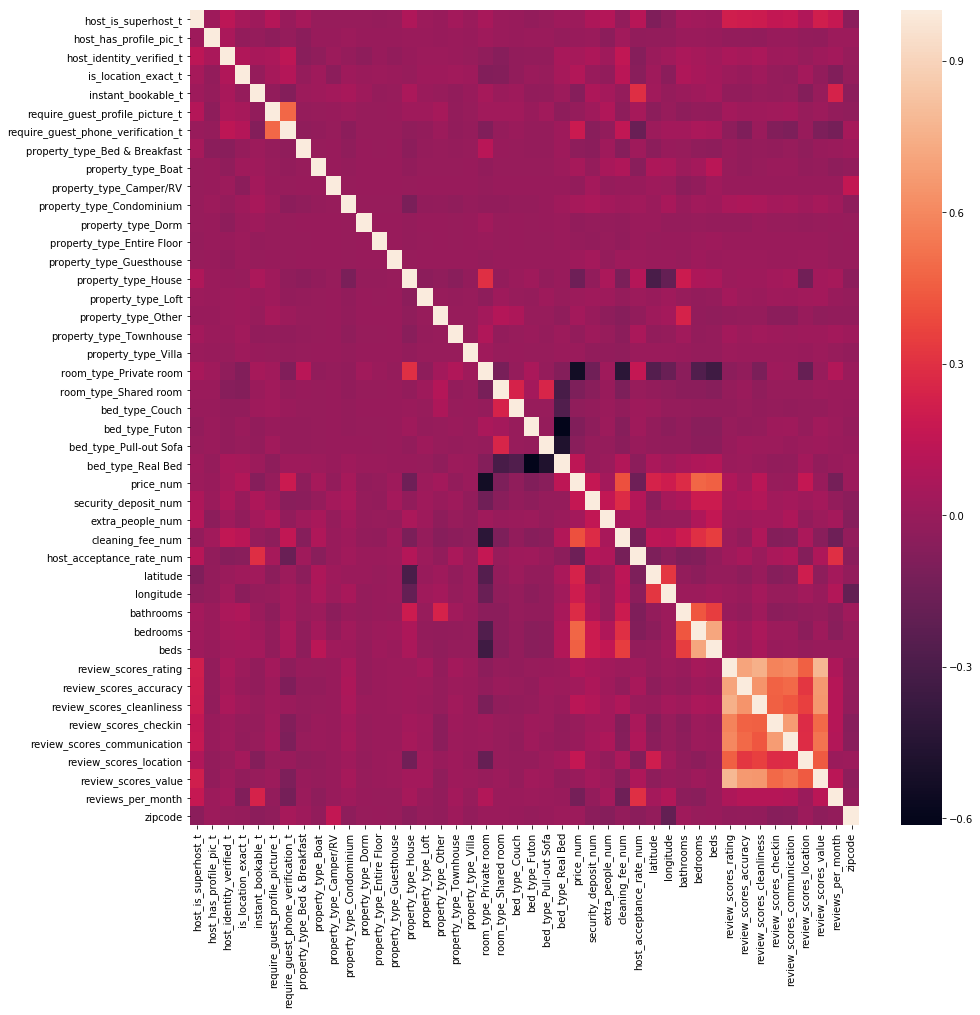

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15));
sns.heatmap(clean_df.corr());
plt.savefig("sns_heatmap.png", bbox_inches='tight', pad_inches=0.1)

One thought is that reviews per month might be correlated to some other variable, which itself has a strong positive or negative correlation. Looking at the correlation plot above, this does not seem like anything is jumping out as driving this as a secondary correlation. It may just be that people who offer somewhat lower rate recieve more guests.

# Section 4 - PCA Dimensionality Reduction and KMeans Clustering Analysis

## PCA Dimensionality Reduction

In [16]:
def do_pca(clean_df):
    
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    '''
    Performs PCA on some dataframe
    
    INPUT: clean_df - dataframe to do pca on
    
    OUTPUT: pca - the pca object fit on the data
    X_pca - the pca transformed data
    X - the data that went into the scaler and pca fit
    '''
    
    # drop the features that arent suitable as pca inputs
    X = clean_df.drop(['geometry', 'property_type_Camper/RV', 'zipcode'], axis=1)
    categories = X.columns

    # scale data for input to pca
    scl = StandardScaler()
    model = scl.fit(X)
    X_scl = model.transform(X)
    
    # instantiate pca object and fit to the data with 10 components
    pca = PCA(n_components=10, random_state=42)
    X_pca = pca.fit_transform(X)
    
    # return the full datatset that went into the pca, as well as the pca object and pca transformed dataset
    return pca, X_pca, X, X_scl

In [17]:
def scree_plot(pca):
    import numpy as np
    import matplotlib.pyplot as plt
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.savefig("scree_plot.png", bbox_inches='tight', pad_inches=0.1)

In [18]:
def pca_results(full_dataset, pca, comp_num, fig_name):
    
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    # Extract component and variance ratios for plotting and making summary dataframe
    dimension = ['PCA Feature {}'.format(comp_num)]
    components = pd.DataFrame(np.round(pca.components_[comp_num-1:comp_num], 4), columns = full_dataset.keys())
    components.index = dimension
    components.sort_values(dimension, axis=1, inplace=True)
    ratio = pca.explained_variance_ratio_[comp_num-1:comp_num]
    variance_ratios = pd.DataFrame(np.round(ratio, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimension
    
    # Make a bar plot of the weights of the input components
    fig, ax = plt.subplots(figsize = (14,8))
    components.plot(ax = ax, kind = 'bar', colormap='plasma');
    ax.set_ylabel("Feature Weights", fontdict={'size':32});
    ax.set_xticklabels(dimension, rotation=0, fontdict={'size':32});
    plt.xlim(right=2)
    ax.legend(fontsize='x-small',ncol=3);
    ax.text(0.8, components.min().min(), 'Explained Variance {}%'.format(np.round(ratio[0]*100,2)), fontdict={'size': 24, 'color': 'b'});
    plt.savefig(fig_name, bbox_inches='tight', pad_inches=0.1)


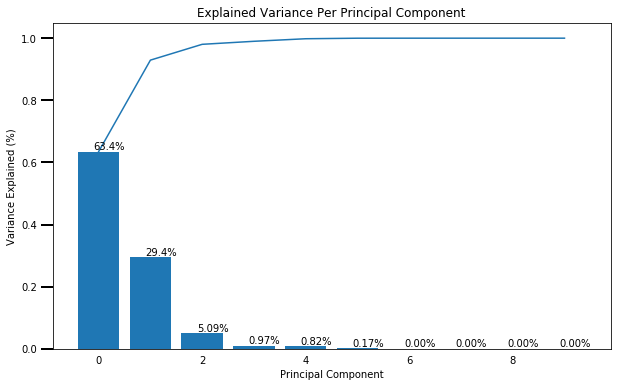

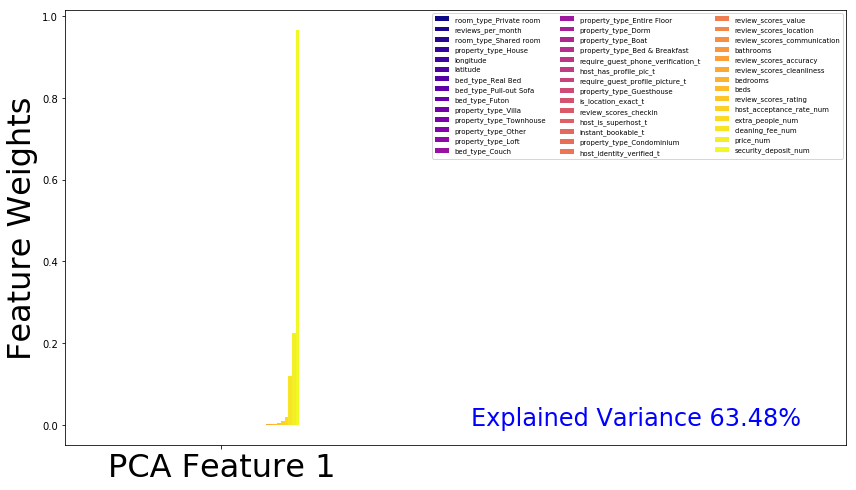

In [19]:
pca, X_pca, X, X_scl = do_pca(clean_df)
scree_plot(pca)
pca_results(X, pca, 1, 'pca1.png')

Examining the results, its clear that PCA is a good idea here. The first component explains over 60% of the variance of the data. Examining the contributions to this component from the original data, it appears that this component reflects houses that have a postive correlation between the security deposit, the price of the rental, a cleaning fee, rating and number of beds and bedrooms. 

It seems that a large amount of the variance is based on the price and the components which are correlated with the price, i.e. the size of the house (bedrooms, beds). Also the presence of a security deposit is correlated with the presence of a cleaning fee, the number of bedrooms and beds.

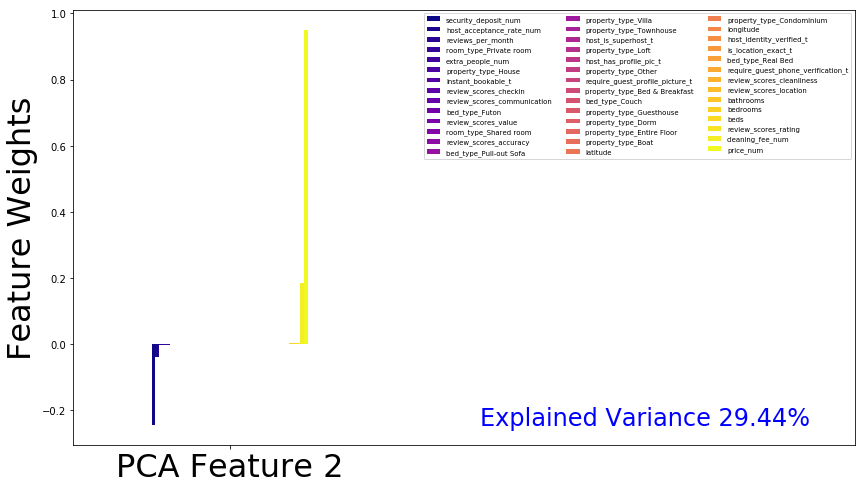

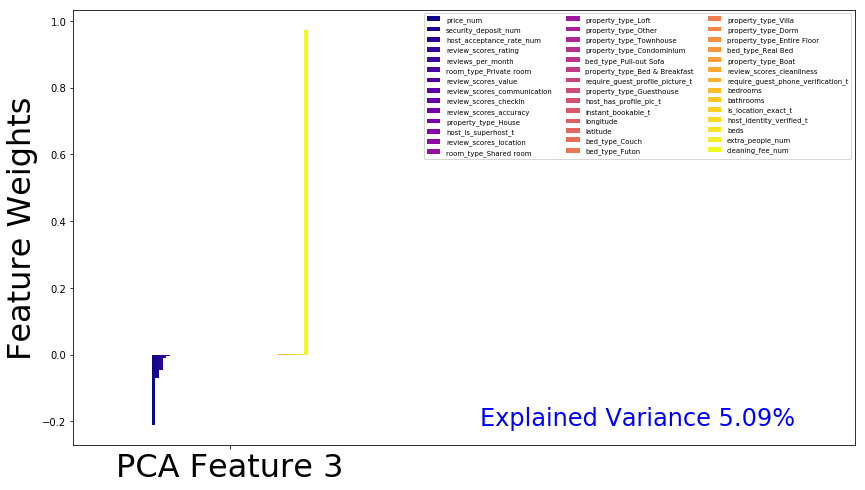

In [20]:
pca_results(X, pca, 2, 'pca2.png')
pca_results(X, pca, 3, 'pca3.png')

The next two features also explain large portions of the variance, however they are different than the first component. 

The second pc shows anti-correlation between price/rating and security deposit/host acceptance rating. This is becoming suggestive of a pattern of people charging security deposits and rejecting guests to offset some of the risk associated with having strangers in your house, and thus offer a lower cost.

The third pc shows anti-correlation between price/deposit/private room and a cleaning fee. I feel like this may be useful in differentiating between shared rooms in houses and full places which are apartments and the like.

## Clustering of the reduced dataset with KMeans

In [21]:
def KMeans_cluster(X):

    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np
    
    '''Takes a dataset and performs KMeans clustering for multiple cluster sizes to determine optimal clustering
       
       Outputs a plot of clusters versus distance to center, to determine optimal cluster size
       
       Also outputs a plot of the optimal cluster size in a 3D graph, since 3 PCs are considered optimal
    
    INPUT: X - a dataset which will be reduced into 3 principle components, and fit with KMeans
    OUPTUT: clusters, the optimal cluster size, which is selected manually inside this function'''

    # 
    reduced_data = PCA(n_components=3, random_state=42).fit_transform(X)
    
    cluster_nums = list(range(1,15))
    distances = []
    
    for c in cluster_nums:
        print('evaluating for {} clusters'.format(c))

        # run k-means clustering on the data and...
        kmeans = KMeans(c, random_state=5)

        preds = kmeans.fit_predict(reduced_data)

        # compute the average within-cluster distances.
        pred_centroids = kmeans.cluster_centers_

        centers = pred_centroids[preds]
        distance = np.sqrt(((reduced_data - centers) ** 2).sum(axis = 1)).mean()
        distances.append(distance)

    # plot distances to center versus number of cluster
    plt.figure(2, figsize=(10,6))
    plt.plot(cluster_nums, distances, '-o')
    plt.ylabel('Avg. distance to centroid')
    plt.xlabel('# of clusters')
    plt.savefig('distance_to_centroid.png')
        
    clusters = KMeans(n_clusters=5, random_state=5).fit(reduced_data)

    # plot the cluster colorings in the 3 dimensions of the pca reduced dataset
    fig = plt.figure(1, figsize=(20, 10));
    ax = Axes3D(fig)
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=clusters.labels_, alpha=1);
    plt.savefig("3d_scatter.png", bbox_inches='tight', pad_inches=0.1)
    plt.rcParams.update({'font.size': 28})
    ax.set_xlabel('PCA Feature 1', labelpad=40)
    ax.set_ylabel('PCA Feature 2', labelpad=40)
    ax.set_zlabel('PCA Feature 3', labelpad=20)
    ax.view_init(50, 50)
    plt.savefig('3d_scatter.png', bbox_inches='tight', pad_inches=0.1)

    return clusters
   

evaluating for 1 clusters
evaluating for 2 clusters
evaluating for 3 clusters
evaluating for 4 clusters
evaluating for 5 clusters
evaluating for 6 clusters
evaluating for 7 clusters
evaluating for 8 clusters
evaluating for 9 clusters
evaluating for 10 clusters
evaluating for 11 clusters
evaluating for 12 clusters
evaluating for 13 clusters
evaluating for 14 clusters


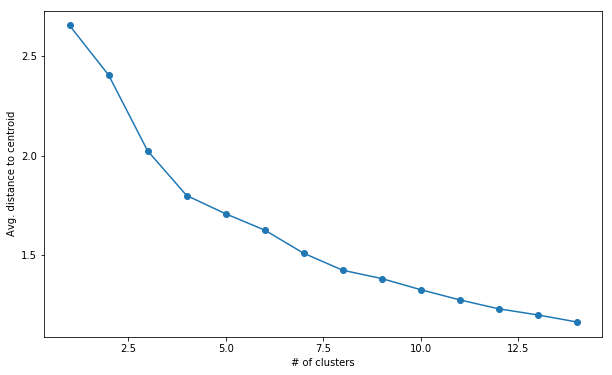

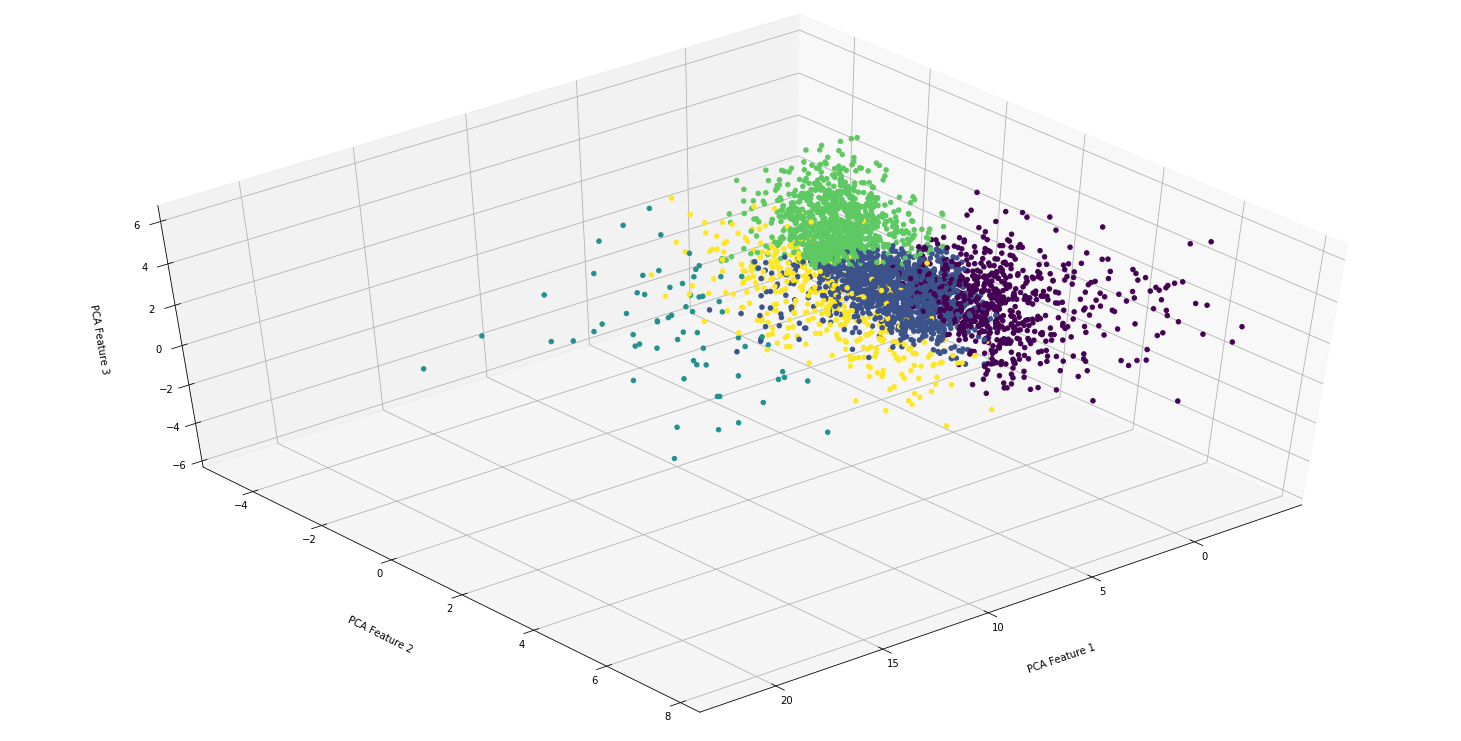

In [22]:
clusters = KMeans_cluster(X_scl)

Examining the distance to the centers of the cluster, it seems like five clusters is a resonable number of clusters to choose, although it is not totally obvious that more clusters wouldnt improve the fit to the data. Based on the 3D plot, it seems that the main grouping of data can be split into four qudrants based on two of the principle components, and then the third dimension splits out another sparse cluster (in yellow). Depending on whether or not you wanted to split out the the sparse data on the edges of the four main clusters, you could imagine choosing up to 9 clusters.

## Ploting the spatial dependence of the clusters

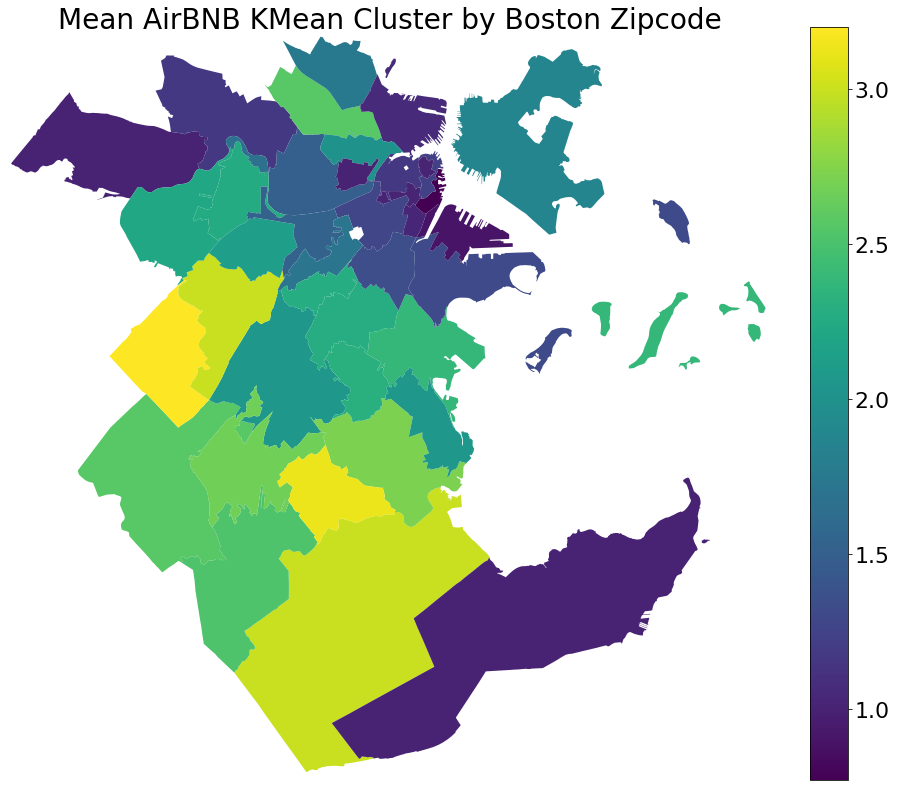

In [30]:
clean_df['pca_clusters'] = clusters.labels_
make_map_plot(clean_df, 'pca_clusters', 'mean', 'Mean_airbnb_cluster.png', 'Mean AirBNB KMean Cluster by Boston Zipcode')

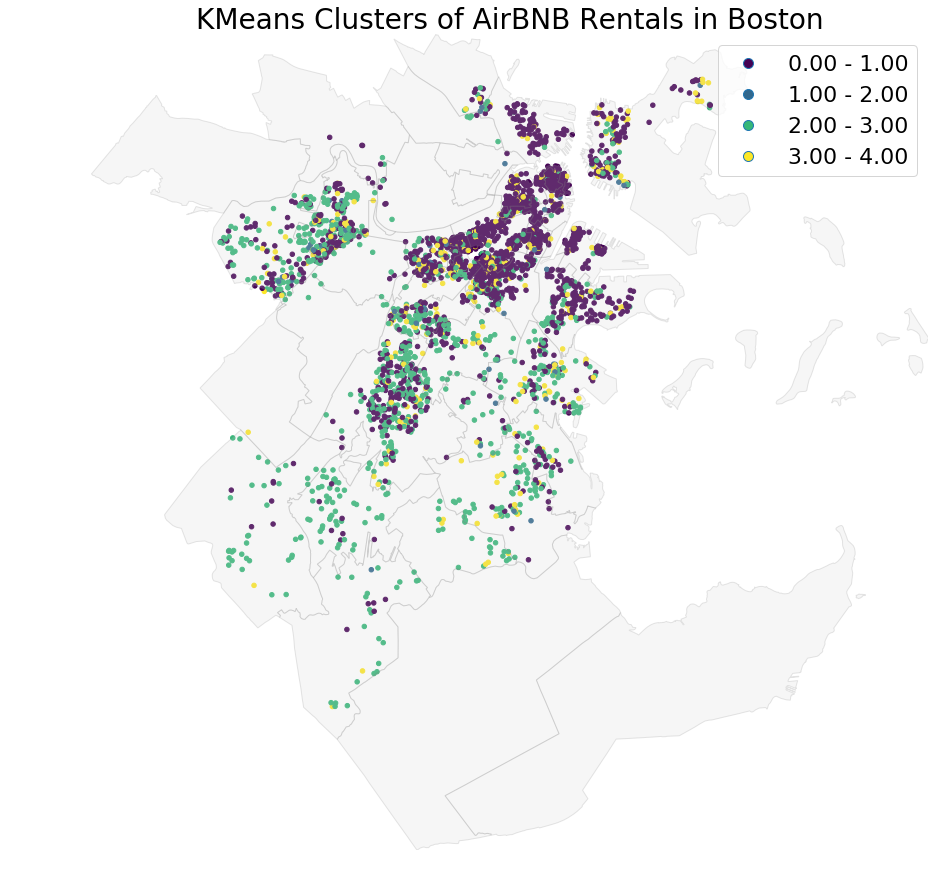

In [31]:
make_points_plot(clean_df, 'pca_clusters', 'scatter_clusters.png', 'KMeans Clusters of AirBNB Rentals in Boston')

In [26]:
clean_df['pca_clusters'].value_counts()

1    1413
3    1010
0     703
4     393
2      66
Name: pca_clusters, dtype: int64

Clustering that data is all well and good, but it does not really give us any information in an of itself. What if we examined the geographic trends, in light of the clustering results? Can we determine any spatial biases in terms of the most prevelant cluster occupancy for a given area?

The maps show what I would argue is a clear geographic trend in the KMeans clusters. Near dowtown, the clusters are much more likely to be part of cluster 1, whereas in the more outlying areas near Waltham, and down near Brookline, are more likely to be cluster 3. 

What are the difference in terms of the inputs that differentiate a 3 from a 1?

In [32]:
def compare_pca_classes(raw_df, class_1, class_2):
    
    import matplotlib.pyplot as plt
    import pandas as pd
    
    '''Take the DataFrame with the pca cluster column, and then compare differences in df columns between different clusters'''
    
    print('Note, as you entered the values, a negative number suggests that {} is less than {} \n'.format(class_2, class_1))
    # get rid of columns excluded during clustering
    df = raw_df.drop(['zipcode','geometry','property_type_Camper/RV'], axis=1)
    
    num1 = class_1
    num2 = class_2
    
    # pull out the dataframe based on cluster occupancy
    class_1 = df[df['pca_clusters'] == class_1]
    class_2 = df[df['pca_clusters'] == class_2]
    
    # look at the differences in mean values between the different groups
    dif = class_2.mean() - class_1.mean()
    
    dif = dif.sort_values()
    bot = dif[:5]
    top = dif[-5:]
    dif = pd.concat((bot,top), axis=0)
    print(dif)
    
    plt.figure(figsize=(10,10));
    plt.barh(dif.index, dif.values);
    plt.savefig("comparing cluster {} and {}.png".format(num1, num2), bbox_inches='tight', pad_inches=0.1)
    

Note, as you entered the values, a negative number suggests that 1 is less than 3 

host_acceptance_rate_num   -11.258062
extra_people_num            -3.931037
pca_clusters                -2.000000
reviews_per_month           -0.929865
room_type_Private room      -0.707505
review_scores_rating         0.270697
review_scores_location       0.392473
security_deposit_num        12.783238
cleaning_fee_num            29.260350
price_num                   88.628836
dtype: float64


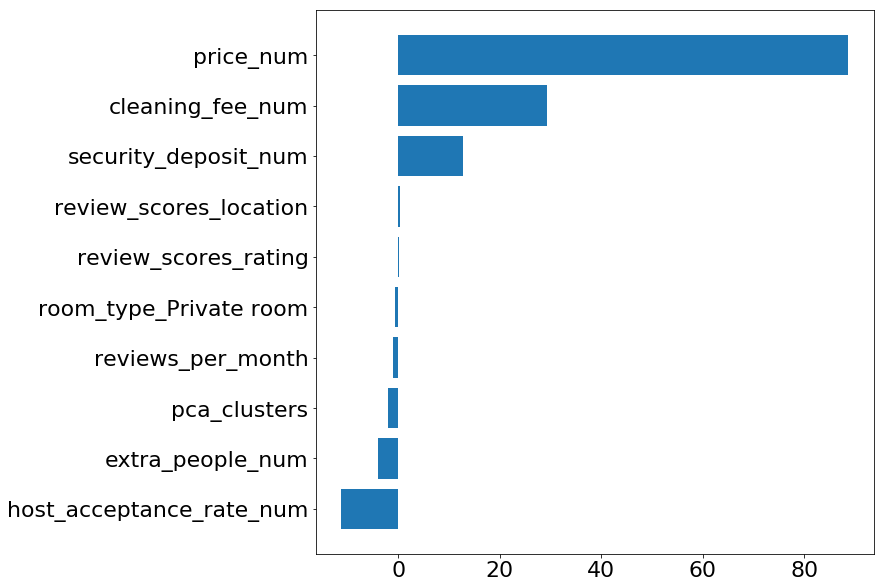

In [33]:
compare_pca_classes(clean_df, 3, 1)

Unsuprisingly in light of earlier analysis, price and security deposit charges are major factors, with the clusters over represented downtown showing more expensive rentals with higher security deposits. Again this is similar to what we learned from just plotting the price in section one, except that it also tells us that these places are also more likely to charge security deposits and cleaning fees that further infalte the price difference.

Additionally, users are more likely to give the downtown AirBNBs higer ratings, and even more so, higher location preference ratings. I imagine that people from very far away may not realize how far somewhere like Brookline or Waltham is from downtown when planning a visit.

Some interesting new information is that the host acceptance rate is signifcantly lower in cluster 1 vs clusters 3, suggesting that the AirBNBs in more popular areas are also more selective in who they allow to rent. The also show more reviews per month, suggesting that they also generate higher occupancy rates versus those outlying places.

Finally, the outlying AirBNBs also seem more likely to be private rooms in peoples houses, which do not allow extra people to stay in them, whereas the AirBNBs downtown are probably more likely to be people or companies engages in full time real estate, and using AirBNB as a service, rather than individuals trying to make a bit of extra money rent out their personal homes.